In [1]:
import os
import torch

import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
# plot
import matplotlib.pyplot as plt
import seaborn as sns
# daa
from data import pre_processing
from datetime import datetime
from datetime import timedelta
from torch_geometric.data import Data
from sklearn.model_selection import KFold
# config
# set seed
torch.manual_seed(42)
np.random.seed(42)
warnings.filterwarnings('ignore')
#plt.style.use('seaborn-darkgrid')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-whitegrid')

# Data - Node features

## Sobe e Desce 01/03/2024

In [2]:
sb = pd.read_csv('/mnt/data/sobe_desce/03_2024/2024-03-01/output/sobe_desce_01-03-2024_esp.csv')
sb = sb.astype({'ponto': str})
sb.head()

,index,linha,cod_ate,sentido,ordem,ponto,veiculo,trip,trip_id,inicio_viagem,fim_viagem,set,hora_ponto,sobe,desce,lag_carregamento,saldo,carregamento,sobe_fit,lag_carregamento_fit,desce_fit,saldo_fit,carregamento_fit,percent_desce,percent_sobe_esp,sobe_especie,sobe_total_especie,lag_carregamento_especie,desce_total_especie,saldo_especie,carregamento_especie,percent_desce_fit
0,569509,1141,12730,I,1,44028970,21201,1,21201_1141_1,2024-03-01 06:07:50,2024-03-01 07:19:33,ottrans,2024-03-01 06:07:50,7.0,0.0,0,0,7,8.0,0.0,0.0,0.0,8.0,0.0,0.207738,0.918203,8.918203,0.000000,0.0,0.000000,8.918203,0.0
1,569510,1141,12730,I,2,44783401,21201,1,21201_1141_1,2024-03-01 06:07:50,2024-03-01 07:19:33,ottrans,2024-03-01 06:07:52,4.0,0.0,7,7,11,5.0,8.0,0.0,8.0,13.0,0.0,0.129836,0.573877,5.573877,8.918203,0.0,8.918203,14.492080,0.0
2,569511,1141,12730,I,3,44783402,21201,1,21201_1141_1,2024-03-01 06:07:50,2024-03-01 07:19:33,ottrans,2024-03-01 06:08:49,4.0,0.0,11,11,15,5.0,13.0,0.0,13.0,18.0,0.0,0.129836,0.573877,5.573877,14.492080,0.0,14.492080,20.065957,0.0
3,569512,1141,12730,I,4,45833865,21201,1,21201_1141_1,2024-03-01 06:07:50,2024-03-01 07:19:33,ottrans,2024-03-01 06:10:12,6.0,0.0,15,15,21,6.0,18.0,0.0,18.0,24.0,0.0,0.155804,0.688652,6.688652,20.065957,0.0,20.065957,26.754609,0.0
4,569513,1141,12730,I,5,44739642,21201,1,21201_1141_1,2024-03-01 06:07:50,2024-03-01 07:19:33,ottrans,2024-03-01 06:11:26,5.0,0.0,21,21,26,6.0,24.0,0.0,24.0,30.0,0.0,0.155804,0.688652,6.688652,26.754609,0.0,26.754609,33.443261,0.0


## Define tresh VM

In [3]:
sb_tresh_loader = sb.pivot_table(index='ponto', 
                                 values='carregamento_fit', 
                                 aggfunc='mean').reset_index()

In [4]:
sb_tresh_loader['q1'] = None
sb_tresh_loader['q2'] = None
sb_tresh_loader['q3'] = None

sb_tresh_loader['tresh'] = None

In [5]:
for i in tqdm(range(sb_tresh_loader.shape[0])):
    stop_id = sb_tresh_loader.ponto.iloc[i]
    
    sb_tresh_loader['tresh'].iloc[i] =  sb.query(f" ponto == '{stop_id}'  ")['carregamento_fit'].mean()
    # qs = sb.query(f" ponto == '{stop_id}'  ")['carregamento_fit'].quantile([0.25, 0.5, 0.75]).values
    # sb_tresh_loader['q1'].iloc[i] = qs[0]
    # sb_tresh_loader['q2'].iloc[i] = qs[1]
    # sb_tresh_loader['q3'].iloc[i] = qs[2]

100% 2860/2860 [00:41<00:00, 68.32it/s]


In [6]:
#sb_tresh_loader.drop(['carregamento_fit'], axis=1).to_csv('stop_ids_quantile_01-03-2024.csv', index=False)

In [7]:
sb_tresh_loader.head()

,ponto,carregamento_fit,q1,q2,q3,tresh
0,100009577,0.569892,None,None,None,0.569892
1,100722777,24.080511,None,None,None,24.080511
2,100722778,23.425442,None,None,None,23.425442
3,101214305,16.419670,None,None,None,16.41967
4,101269104,27.675124,None,None,None,27.675124


In [8]:
sb_tresh_loader.query(" tresh <= 0 ")

,ponto,carregamento_fit,q1,q2,q3,tresh
638,43768586,0.0,None,None,None,0.0


<AxesSubplot:>

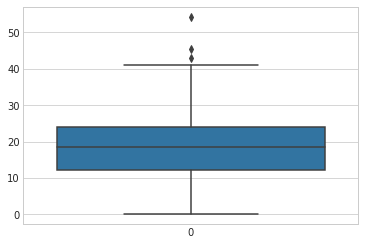

In [9]:
sns.boxplot(sb_tresh_loader.tresh.values)

In [10]:
# sb_tresh_loader.query(f" q1 == q2 ")

In [11]:
# sb_tresh_loader.query(f" q2 == q3 ")

In [12]:
sb_tresh_loader.ponto.nunique()

2860

In [13]:
# remove nodes without quatiles
#nodes_to_delete = list(sb_tresh_loader.query(f" q1 == q2 ").ponto.unique())
#nodes_to_delete = list(sb_tresh_loader.query(f" q1 == q2 ").ponto.unique())
#nodes_to_delete.extend(list(sb_tresh_loader.query(f" q2 == q3").ponto.unique()))
#nodes_to_delete = list(set(nodes_to_delete))
#nodes_to_delete

In [14]:
# selected nodes to task classification
sb_tresh_loader_selected = sb_tresh_loader.copy()#.query(f" ponto not in @nodes_to_delete ")
sb_tresh_loader_selected.shape, sb_tresh_loader.shape

((2860, 6), (2860, 6))

In [15]:
# save dataframe
sb_tresh_loader_selected.drop(['carregamento_fit'], axis=1).to_csv('../../data/graph_designer/train_test_node_classification_days/stop_id_quartis.csv', index=False)

## Sobe Desce Data Train (08/03/2024)

In [16]:
# read sobe e desce from another day
sb_train = pd.read_csv('/mnt/data/sobe_desce/03_2024/2024-03-08/output/sobe_desce_08-03-2024_esp.csv')
sb_train['hora_ponto'] = pd.to_datetime(sb_train['hora_ponto'], format='%Y-%m-%d %H:%M:%S')
sb_train = sb_train.rename({'ponto': 'stop_id'}, axis=1)
sb_train = sb_train.astype({'stop_id': 'str'})
sb_train.head()

,index,linha,cod_ate,sentido,ordem,stop_id,veiculo,trip,trip_id,inicio_viagem,fim_viagem,set,hora_ponto,sobe,desce,lag_carregamento,saldo,carregamento,sobe_fit,lag_carregamento_fit,desce_fit,saldo_fit,carregamento_fit,percent_desce,percent_sobe_esp,sobe_especie,sobe_total_especie,lag_carregamento_especie,desce_total_especie,saldo_especie,carregamento_especie,percent_desce_fit
0,11353,1137,33228,I,1,45833577,20937,1,20937_1137_1,2024-03-08 05:10:32,2024-03-08 05:37:51,ottrans,2024-03-08 05:10:32,11.0,0.0,0,0,11,11.0,0.0,0.0,0.0,11.0,0.0,1.270208,1.765589,12.765589,0.000000,0.0,0.000000,12.765589,0.0
1,11354,1137,33228,I,2,45833578,20937,1,20937_1137_1,2024-03-08 05:10:32,2024-03-08 05:37:51,ottrans,2024-03-08 05:10:59,9.0,0.0,11,11,20,9.0,11.0,0.0,11.0,20.0,0.0,1.039261,1.444573,10.444573,12.765589,0.0,12.765589,23.210162,0.0
2,11355,1137,33228,I,3,45832840,20937,1,20937_1137_1,2024-03-08 05:10:32,2024-03-08 05:37:51,ottrans,2024-03-08 05:13:13,1.0,0.0,20,20,21,1.0,20.0,0.0,20.0,21.0,0.0,0.115473,0.160508,1.160508,23.210162,0.0,23.210162,24.370670,0.0
3,11356,1137,33228,I,4,45833571,20937,1,20937_1137_1,2024-03-08 05:10:32,2024-03-08 05:37:51,ottrans,2024-03-08 05:14:04,3.0,0.0,21,21,24,3.0,21.0,0.0,21.0,24.0,0.0,0.346420,0.481524,3.481524,24.370670,0.0,24.370670,27.852194,0.0
4,11357,1137,33228,I,5,45832819,20937,1,20937_1137_1,2024-03-08 05:10:32,2024-03-08 05:37:51,ottrans,2024-03-08 05:14:42,5.0,0.0,24,24,29,5.0,24.0,0.0,24.0,29.0,0.0,0.577367,0.802540,5.802540,27.852194,0.0,27.852194,33.654734,0.0


In [17]:
# criar o atributo da faixa
sb_train['faixa'] = sb_train.hora_ponto.dt.hour

### Trip Time Series 

Trazer a velolidade media

In [18]:
tts = pd.read_parquet(f'/mnt/data/sobe_desce/03_2024/2024-03-08/output/trips_time-series_08-03-2024_08-03-2024.parquet')
tts.head()

,linha_atend,linha,cod_ate,sentido,shape,ordem,stop_id,lat,lon,distancias,acumulado,posicao,veiculo,trip,trip_id,inicio_viagem,fim_viagem,set,hora_ponto,saida,fill,tempo_parada,duracao,tempo_total,tempo_parada_acum,duracao_acum,distancia,dis_acum,vm,vm_acum,type
0,1374_30966,1374,30966,I,30966_I,1,110438500,-12.942272,-38.421867,0.000,0.000,inicial,20771,1.0,20771_1374_1,2024-03-08 06:25:17,2024-03-08 06:44:25,ottrans,2024-03-08 06:25:17,2024-03-08 06:26:05,False,48.0,0.0,48.0,48.0,0.0,0.000000,0.000000,0.000000,0.000000,bus
1,1374_30966,1374,30966,I,30966_I,2,110952763,-12.940207,-38.427055,0.922,0.922,intermediario,20771,1.0,20771_1374_1,2024-03-08 06:25:17,2024-03-08 06:44:25,ottrans,2024-03-08 06:27:01,2024-03-08 06:27:05,False,4.0,56.0,60.0,52.0,56.0,0.607295,0.000000,39.040412,0.000000,bus
2,1374_30966,1374,30966,I,30966_I,3,110952766,-12.937143,-38.425938,0.391,1.313,intermediario,20771,1.0,20771_1374_1,2024-03-08 06:25:17,2024-03-08 06:44:25,ottrans,2024-03-08 06:28:03,2024-03-08 06:28:10,False,7.0,58.0,65.0,59.0,114.0,0.361609,0.607295,22.444727,19.177746,bus
3,1374_30966,1374,30966,I,30966_I,4,45833801,-12.934586,-38.425152,0.386,1.699,intermediario,20771,1.0,20771_1374_1,2024-03-08 06:25:17,2024-03-08 06:44:25,ottrans,2024-03-08 06:29:41,2024-03-08 06:30:23,False,42.0,91.0,133.0,101.0,205.0,0.296886,0.968905,11.744958,17.014913,bus
4,1374_30966,1374,30966,I,30966_I,5,45833482,-12.933431,-38.422264,0.457,2.156,intermediario,20771,1.0,20771_1374_1,2024-03-08 06:25:17,2024-03-08 06:44:25,ottrans,2024-03-08 06:31:21,2024-03-08 06:31:32,False,11.0,58.0,69.0,112.0,263.0,0.338278,1.265791,20.996542,17.326420,bus


In [19]:
# merge com o sobe e desce para trazer a velocidade media
sb_train.shape, tts.shape

((735127, 33), (735271, 31))

In [20]:
# stats vm
tts['vm'].describe()

count    7.351870e+05
mean              inf
std               NaN
min     -1.186500e+04
25%      1.618871e+01
50%      2.576449e+01
75%      3.851233e+01
max               inf
Name: vm, dtype: float64

In [21]:
tts['vm'][tts['vm'] < 0] = pd.NA
tts['vm'][tts['vm'] > 80] = pd.NA
tts['vm'] = tts['vm'].fillna(method='ffill')

In [22]:
sb_vm = sb_train.merge(tts[['trip_id', 'sentido', 'stop_id', 'ordem', 'vm']], 
                       on=['trip_id',  'sentido', 'stop_id', 'ordem'], 
                       how='left')

In [23]:
sb_vm.shape

(735127, 34)

In [24]:
# selecionar a faixa horária para treinamento e teste
#sb_vm_faixa = sb_vm.query(" faixa in [6, 7, 8,] ")
sb_vm_faixa = sb_vm.query(" faixa == 18 ")

### Agregation funtions to get node features

In [25]:
# loader
nf_loader = sb_vm_faixa.pivot_table(index=['stop_id'], 
                                    values='carregamento_fit', 
                                    aggfunc='mean').reset_index()
# sobe
nf_sobe = sb_vm_faixa.pivot_table(index='stop_id', 
                        values='sobe_fit', 
                        aggfunc='sum').reset_index()
# desce
nf_desce = sb_vm_faixa.pivot_table(index='stop_id', 
                        values='desce_fit', 
                        aggfunc='sum').reset_index()
# veiculos
nf_veic = sb_vm_faixa.pivot_table(index='stop_id', 
                        values='veiculo', 
                        aggfunc=pd.Series.nunique).reset_index()
# linhas
nf_lines = sb_vm_faixa.pivot_table(index='stop_id', 
                        values='linha', 
                        aggfunc=pd.Series.nunique).reset_index()
# viagens
nf_trips = sb_vm_faixa.pivot_table(index='stop_id', 
                        values='trip_id', 
                        aggfunc=pd.Series.nunique).reset_index()

# vm
nf_vm = sb_vm_faixa.pivot_table(index='stop_id', 
                        values='vm', 
                        aggfunc='mean').reset_index()

In [26]:
# Merge the DataFrames on the 'stop_id' column
merged_df = nf_sobe.merge(nf_desce, on='stop_id', suffixes=('_sobe', '_desce'))
merged_df = merged_df.merge(nf_veic, on='stop_id')
merged_df = merged_df.merge(nf_lines, on='stop_id')
merged_df = merged_df.merge(nf_trips, on='stop_id')
merged_df = merged_df.merge(nf_vm, on='stop_id')
merged_df = merged_df.merge(nf_loader, on='stop_id')

# Rename columns for clarity (optional)
merged_df.columns = ['stop_id', 'sobe_fit', 'desce_fit', 'veiculo', 'linha', 'trip_id', 'vm', 'carregamento_fit']

merged_df.head()

,stop_id,sobe_fit,desce_fit,veiculo,linha,trip_id,vm,carregamento_fit
0,100009577,1.0,0.000000,6,2,6,0.000000,0.333333
1,100722777,85.0,73.518128,17,6,17,15.842762,37.118064
2,100722778,1.0,24.895921,20,7,20,8.064033,30.785752
3,101214305,4.0,45.700843,3,1,3,20.036531,35.180215
4,101269104,198.0,75.066624,68,24,68,24.763056,46.030173


### add Target

In [27]:
sb_tresh_loader_selected.head()
sb_tresh_loader_selected = sb_tresh_loader_selected.astype({'ponto': str})

In [28]:
def select_target(stop_id, vm):
    
    df_stop = sb_tresh_loader_selected.query(f" ponto == '{stop_id}' ")
    if df_stop.shape[0] > 0:
        qts = df_stop[['q1', 'q2', 'q3']].values[0]
        if vm <= qts[0]:
            return 'baixo'
        elif (vm > qts[0]) and (vm <= qts[1]):
            return 'normal'
        elif (vm > qts[1]) and (vm <= qts[2]):
            return 'alto'
        elif vm > qts[2]:
            return 'elevado'
    
    return 'sem_classe'

In [29]:
def select_target_loader(stop_id, ocupation):
    
    df_stop = sb_tresh_loader_selected.query(f" ponto == '{stop_id}' ")
    
    if df_stop.shape[0] > 0:
        tresh = df_stop['tresh'].values[0]
        if ocupation <= tresh:
            return 'baixo'
        elif ocupation > tresh:
            return 'alta'
    
    return 'sem_classe'

In [30]:
# s, v = merged_df[['stop_id', 'vm']].iloc[1]
# s, v

In [31]:
merged_df['target_loader'] = None
for idx in tqdm(range(merged_df.shape[0])):
    s, v = merged_df[['stop_id', 'carregamento_fit']].iloc[idx]
    merged_df['target_loader'].iloc[idx] = select_target_loader(s, v)    

100% 2810/2810 [00:05<00:00, 542.64it/s]


In [32]:
# qts_sample = sb_tresh_loader_selected.query(f" ponto == '{s}' ")[['q1', 'q2', 'q3']].values[0]
# qts_sample

In [33]:
merged_df.target_loader.value_counts(dropna=False)

alta     1689
baixo    1121
Name: target_loader, dtype: int64

In [34]:
1689 / (1689+1121)

0.601067615658363

In [35]:
df_node_features = merged_df.query(" target_loader not in ['sem_classe'] ")
df_node_features.head()

,stop_id,sobe_fit,desce_fit,veiculo,linha,trip_id,vm,carregamento_fit,target_loader
0,100009577,1.0,0.000000,6,2,6,0.000000,0.333333,baixo
1,100722777,85.0,73.518128,17,6,17,15.842762,37.118064,alta
2,100722778,1.0,24.895921,20,7,20,8.064033,30.785752,alta
3,101214305,4.0,45.700843,3,1,3,20.036531,35.180215,alta
4,101269104,198.0,75.066624,68,24,68,24.763056,46.030173,alta


In [36]:
'''
elevado       1226
alto           992
normal         464
baixo          124
sem_classe      10
'''

'\nelevado       1226\nalto           992\nnormal         464\nbaixo          124\nsem_classe      10\n'

## Edge Features

In [37]:
df_edges_features = pd.read_parquet('../../data/graph_designer/graph_gtfs_fev_2024.parquet')
df_edges_features.head()

,src,dst,distance,src_lat,dst_lat,src_lon,dst_lon
0,100009577,345936831,0.254,-12.901954,-12.902051,-38.419582,-38.417114
1,100722777,100722778,0.362,-12.899299,-12.896647,-38.407673,-38.408215
2,100722777,44782645,1.062,-12.899299,-12.899458,-38.407673,-38.412964
3,100722777,45833440,0.417,-12.899299,-12.896741,-38.407673,-38.408672
4,100722777,66771046,0.934,-12.899299,-12.896790,-38.407673,-38.412540


## Pre-processamento

In [38]:
df_node_features.head()

,stop_id,sobe_fit,desce_fit,veiculo,linha,trip_id,vm,carregamento_fit,target_loader
0,100009577,1.0,0.000000,6,2,6,0.000000,0.333333,baixo
1,100722777,85.0,73.518128,17,6,17,15.842762,37.118064,alta
2,100722778,1.0,24.895921,20,7,20,8.064033,30.785752,alta
3,101214305,4.0,45.700843,3,1,3,20.036531,35.180215,alta
4,101269104,198.0,75.066624,68,24,68,24.763056,46.030173,alta


In [39]:
# columns to select as features
#features_cols = ['sobe_fit', 'linha', 'sobe_fit', 'trip_id', 'veiculo', 'target_loader']
features_cols = ['sobe_fit', 'linha', 'trip_id', 'veiculo', 'target_loader']

#df_node_features = df_node_features.drop(['target_loader'], axis=1)
df_node_features = df_node_features.rename({'stop_id': 'leg_pos'}, axis=1)
df_node_features = df_node_features.astype({'leg_pos': str})

In [40]:
df_edges_features = df_edges_features.rename({'src': 'pos1', 'dst': 'pos2', 'distance': 'weight'}, axis=1)
df_edges_features = df_edges_features.astype({'pos1': str, 'pos2': str})
df_edges_features.head()

,pos1,pos2,weight,src_lat,dst_lat,src_lon,dst_lon
0,100009577,345936831,0.254,-12.901954,-12.902051,-38.419582,-38.417114
1,100722777,100722778,0.362,-12.899299,-12.896647,-38.407673,-38.408215
2,100722777,44782645,1.062,-12.899299,-12.899458,-38.407673,-38.412964
3,100722777,45833440,0.417,-12.899299,-12.896741,-38.407673,-38.408672
4,100722777,66771046,0.934,-12.899299,-12.896790,-38.407673,-38.412540


In [41]:
x, y, edge_index, edge_weights, pos =  pre_processing(df_edges_features, 
                                                                df_node_features, 
                                                                features_cols,
                                                                col_target='target_loader')

100% 2810/2810 [00:10<00:00, 270.44it/s]


In [42]:
# one hot encoding
y_ohe = torch.nn.functional.one_hot(y).float()
y_ohe.shape

torch.Size([2810, 2])

In [43]:
y = y.unsqueeze(1)

In [44]:
from collections import Counter

In [45]:
Counter(list(y.numpy().flatten()))

Counter({1: 1121, 0: 1689})

In [46]:
x.shape, y.shape, edge_index.shape, edge_weights.shape, y_ohe.shape

(torch.Size([2810, 5]),
 torch.Size([2810, 1]),
 torch.Size([4418, 2]),
 torch.Size([4418, 1]),
 torch.Size([2810, 2]))

## Select faixa to train and test k-fold cross validation

In [47]:
folder = '../../data/graph_designer/train_test_node_classification_days/'

In [48]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(x)):
    fold_idx = fold + 1
    print(f"Fold {fold_idx}")

    # Create Data objects
    data = Data(
        x=x,
        y=y.float(),
        edge_index=edge_index.t(),
        edge_attr=edge_weights
    )

    
    data['train_mask'] = train_idx
    data['test_mask'] = test_idx
    
    # save
    torch.save(data, f'{folder}data_{fold_idx}.pt')

    # Print out the fold results (or store them for later analysis)
    print(f"Train data: {data}")

Fold 1
Train data: Data(x=[2810, 5], edge_index=[2, 4418], edge_attr=[4418, 1], y=[2810, 1], train_mask=[2529], test_mask=[281])
Fold 2
Train data: Data(x=[2810, 5], edge_index=[2, 4418], edge_attr=[4418, 1], y=[2810, 1], train_mask=[2529], test_mask=[281])
Fold 3
Train data: Data(x=[2810, 5], edge_index=[2, 4418], edge_attr=[4418, 1], y=[2810, 1], train_mask=[2529], test_mask=[281])
Fold 4
Train data: Data(x=[2810, 5], edge_index=[2, 4418], edge_attr=[4418, 1], y=[2810, 1], train_mask=[2529], test_mask=[281])
Fold 5
Train data: Data(x=[2810, 5], edge_index=[2, 4418], edge_attr=[4418, 1], y=[2810, 1], train_mask=[2529], test_mask=[281])
Fold 6
Train data: Data(x=[2810, 5], edge_index=[2, 4418], edge_attr=[4418, 1], y=[2810, 1], train_mask=[2529], test_mask=[281])
Fold 7
Train data: Data(x=[2810, 5], edge_index=[2, 4418], edge_attr=[4418, 1], y=[2810, 1], train_mask=[2529], test_mask=[281])
Fold 8
Train data: Data(x=[2810, 5], edge_index=[2, 4418], edge_attr=[4418, 1], y=[2810, 1], trai